# Finding Regions

For each zillow region:
1. Find k closest neighbors
2. Find k closest taxi neighbors
3. Using the edge data, compare connected subregions

In [1]:
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates

In [2]:
import geojson
from shapely.geometry import mapping, shape
taxi_zones = geojson.load(open('taxi_zones.geojson'))
z_hoods = geojson.load(open('ZillowNeighborhoods-NY.geojson'))

class Neighborhood(object):
    def __init__(self, feature):
        self.properties = feature['properties']
        self.geometry = feature['geometry']
        self.shape = shape(feature['geometry'])

z_hoods_shapes = [Neighborhood(f)
                  for f in z_hoods['features']
                  if f['properties']['City'] == 'New York']
taxi_zones_shapes = [Neighborhood(f) for f in taxi_zones['features']]

In [5]:
print('Zillow neighborhoods:', len(z_hoods_shapes))
print('Taxi zones:', len(taxi_zones_shapes))

Zillow neighborhoods: 278
Taxi zones: 263


Visualize what "close" areas look like.

In [87]:
############################
# How many nearby regions to consider when looking for groups?
K = 5
############################

from shapely.geometry.point import Point
test_pt = z_hoods_shapes[8].shape.centroid

# 10 closest z's and t's
near_zs = sorted(z_hoods_shapes[:], key=lambda z:test_pt.distance(z.shape.centroid))[:K]
near_ts = sorted(taxi_zones_shapes[:], key=lambda t:test_pt.distance(t.shape.centroid))[:K]

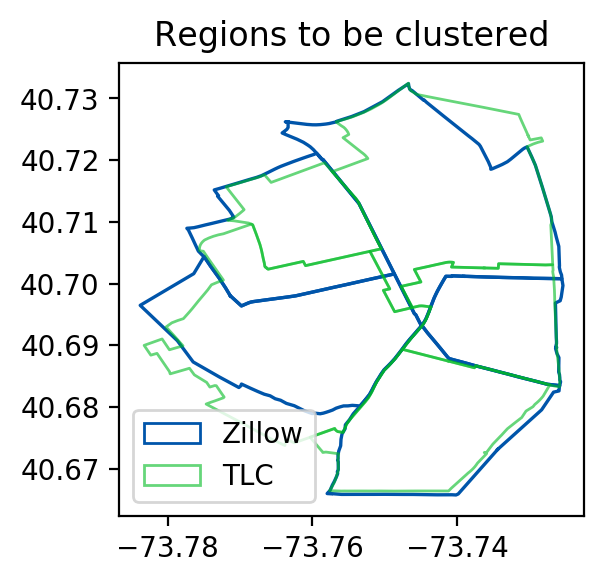

In [88]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

z_col = '#0055aaff'
t_col = '#00bb2299'

z_patch = mpatches.Patch(facecolor='white', edgecolor=z_col, label='Zillow')
t_patch = mpatches.Patch(facecolor='white', edgecolor=t_col, label='TLC')

def plot(shape, **kwargs):
    if shape.type == 'MultiPolygon':
        for g in shape.geoms:
            plot(g, **kwargs)
    else:
        x, y = shape.exterior.xy
        plt.plot(x ,y, **kwargs)

plt.figure(figsize=(3,3))
plt.title('Regions to be clustered')
[plot(z.shape, color=z_col, linewidth=1.2) for z in near_zs]
[plot(t.shape, color=t_col, linewidth=1) for t in near_ts]
plt.legend(handles=[z_patch, t_patch], loc='best')
plt.show()

In [80]:
# Load adjacency data.
import json
t_edges = json.load(open('taxi_zones_LocationID_edges.json', 'r'))
z_edges = json.load(open('ZillowNeighborhoods_RegionID_edges.json', 'r'))

In [81]:
len(t_edges)

895

In [109]:
# Fit them into graphs.
import networkx as nx
T = nx.Graph()
T.add_edges_from(t_edges)
T = nx.freeze(T)
Z = nx.Graph()
Z.add_edges_from(z_edges)
Z = nx.freeze(Z)

In [103]:
z_ids = [int(z.properties['RegionID']) for z in near_zs]
t_ids = [int(t.properties['LocationID']) for t in near_ts]
Tnear = T.subgraph(t_ids)
Znear = Z.subgraph(z_ids)

In [104]:
import itertools
def generate_connected_subgraphs(G):
    all_nodes = list(G)
    for sz in xrange(1, len(G)):
        for nodes in itertools.combinations(all_nodes, sz):
            subG = G.subgraph(nodes)
            if nx.is_connected(subG):
                yield subG
    yield G

In [105]:
print(len([list(x) for x in list(generate_connected_subgraphs(Tnear))]))
print(len([list(x) for x in list(generate_connected_subgraphs(Znear))]))

26
28


# Computing for K=5

In [106]:
regionid_to_z = {int(z.properties['RegionID']): z for z in z_hoods_shapes}
locid_to_t = {int(t.properties['LocationID']): t for t in taxi_zones_shapes}

In [161]:
from shapely.ops import cascaded_union

# Map of ([z_regions], [t_regions]) -> score.
clusters = {}
threshold = 0.5

def score_fn(shape_t, shape_z):
    inters = shape_t.intersection(shape_z).area
    union = shape_t.union(shape_z).area
    return inters / union

for i, z0 in enumerate(z_hoods_shapes):
    z0_id = z0.properties['RegionID']
    test_pt = z0.shape.centroid
    near_zs = sorted(z_hoods_shapes[:], key=lambda z:test_pt.distance(z.shape.centroid))[:K]
    # Taxi zones are in general more granular
    near_ts = sorted(taxi_zones_shapes[:], key=lambda t:test_pt.distance(t.shape.centroid))[:K+2]
    
    Tnear = T.subgraph([int(t.properties['LocationID']) for t in near_ts])
    Znear = Z.subgraph([int(z.properties['RegionID']) for z in near_zs])
    
    t_subgs = [list(x) for x in list(generate_connected_subgraphs(Tnear))]
    z_subgs = [list(x) for x in list(generate_connected_subgraphs(Znear))]
    
    comp = 0
    ins = 0
    for t_ids in t_subgs:
        t_shape = cascaded_union([locid_to_t[locid].shape for locid in t_ids])
        for z_ids in z_subgs:
            key = (tuple(sorted(t_ids)), tuple(sorted(z_ids)))
            if key in clusters:
                continue
            comp += 1
            z_shape = cascaded_union([regionid_to_z[regid].shape for regid in z_ids])
            score = score_fn(t_shape, z_shape)
            if score > threshold:
                ins += 1
                clusters[key] = score
    
    log = '({}/{}) {} {}: comp={}, ins={}, len={}'.format(
        i + 1, len(z_hoods_shapes),
        int(z0.properties['RegionID']),
        z0.properties['Name'],
        comp,
        ins,
        len(clusters))
    print(log)

(1/278) 6719 Rego Park: comp=2418, ins=165, len=165
(2/278) 10329 Belle Harbor: comp=195, ins=3, len=168
(3/278) 20239 Roosevelt Island: comp=171, ins=3, len=171
(4/278) 21970 Howard Beach: comp=390, ins=55, len=226
(5/278) 37557 Breezy Point: comp=495, ins=4, len=230
(6/278) 42662 Neponsit: comp=192, ins=0, len=230
(7/278) 45032 East Elmhurst: comp=1438, ins=310, len=540
(8/278) 48417 West Farms: comp=1265, ins=56, len=596
(9/278) 50348 Cambria Heights: comp=1988, ins=245, len=841
(10/278) 4819 Fresh Meadows: comp=1863, ins=72, len=913
(11/278) 5837 Maspeth: comp=989, ins=153, len=1066
(12/278) 8731 Fort Hamilton: comp=672, ins=58, len=1124
(13/278) 16920 Bay Terrace: comp=1656, ins=35, len=1159
(14/278) 18071 Far Rockaway: comp=264, ins=16, len=1175
(15/278) 25160 Hollis: comp=1850, ins=222, len=1397
(16/278) 25294 Jamaica: comp=1816, ins=230, len=1627
(17/278) 27182 South Ozone Park: comp=2349, ins=356, len=1983
(18/278) 35472 Ellis Island: comp=112, ins=4, len=1987
(19/278) 37309 B

In [162]:
pairs = list(clusters.items())
len(pairs)

24347

In [204]:
spairs = sorted(pairs, key=lambda x: x[1] * .985**max(len(x[0][0]), len(x[0][1])), reverse=True)
spairs[:10]

[(((240, 259), (343206, 343225, 403208)), 0.9590000188045125),
 (((16, 64, 175), (26254, 37309, 273478)), 0.9525211369823026),
 (((159,), (403210,)), 0.9236390472825968),
 (((70, 129, 207), (45032, 274117)), 0.9407481306237684),
 (((43,), (273205,)), 0.9016649704135736),
 (((198,), (275173,)), 0.8968870766120381),
 (((19, 101), (55801, 403225, 403226)), 0.9230826380197746),
 (((174, 240, 259), (343206, 343225, 403208, 403213)), 0.9362369775882955),
 (((177,), (270902,)), 0.8921079044571634),
 (((190,), (403161,)), 0.8823860469295666)]

In [212]:
import pickle
pickle.dump(spairs, open('TLocID_ZRegID_Score.pickle', 'wb'))

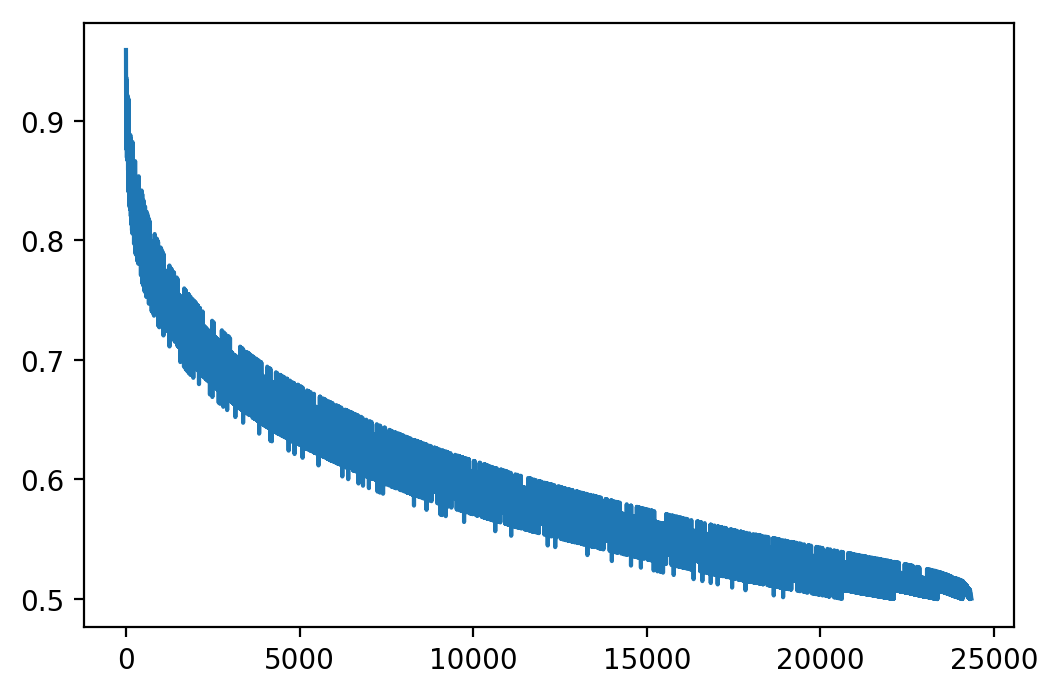

In [206]:
plt.figure()
plt.plot([score for cluster, score in spairs])
plt.show()

In [207]:
# Visualize.
t_shapes = []
z_shapes = []
t_seen = {}
z_seen = {}
cleaned_pairs = []
for (t_ids, z_ids), _ in spairs[:]:
    if any((t in t_seen) for t in t_ids) or any((z in z_seen) for z in z_ids):
        continue
    for t in t_ids:
        t_seen[t] = True
    for z in z_ids:
        z_seen[z] = True
    cleaned_pairs.append((t_ids, z_ids))

    t_shape = cascaded_union([locid_to_t[locid].shape for locid in t_ids])
    z_shape = cascaded_union([regionid_to_z[regid].shape for regid in z_ids])
    t_shapes.append(t_shape)
    z_shapes.append(z_shape)

In [208]:
print(len(cleaned_pairs))
len(z_shapes)

111


111

In [211]:
import pickle
# De-duplicated
pickle.dump(spairs, open('TLocID_ZRegID_pairs.pickle', 'wb'))

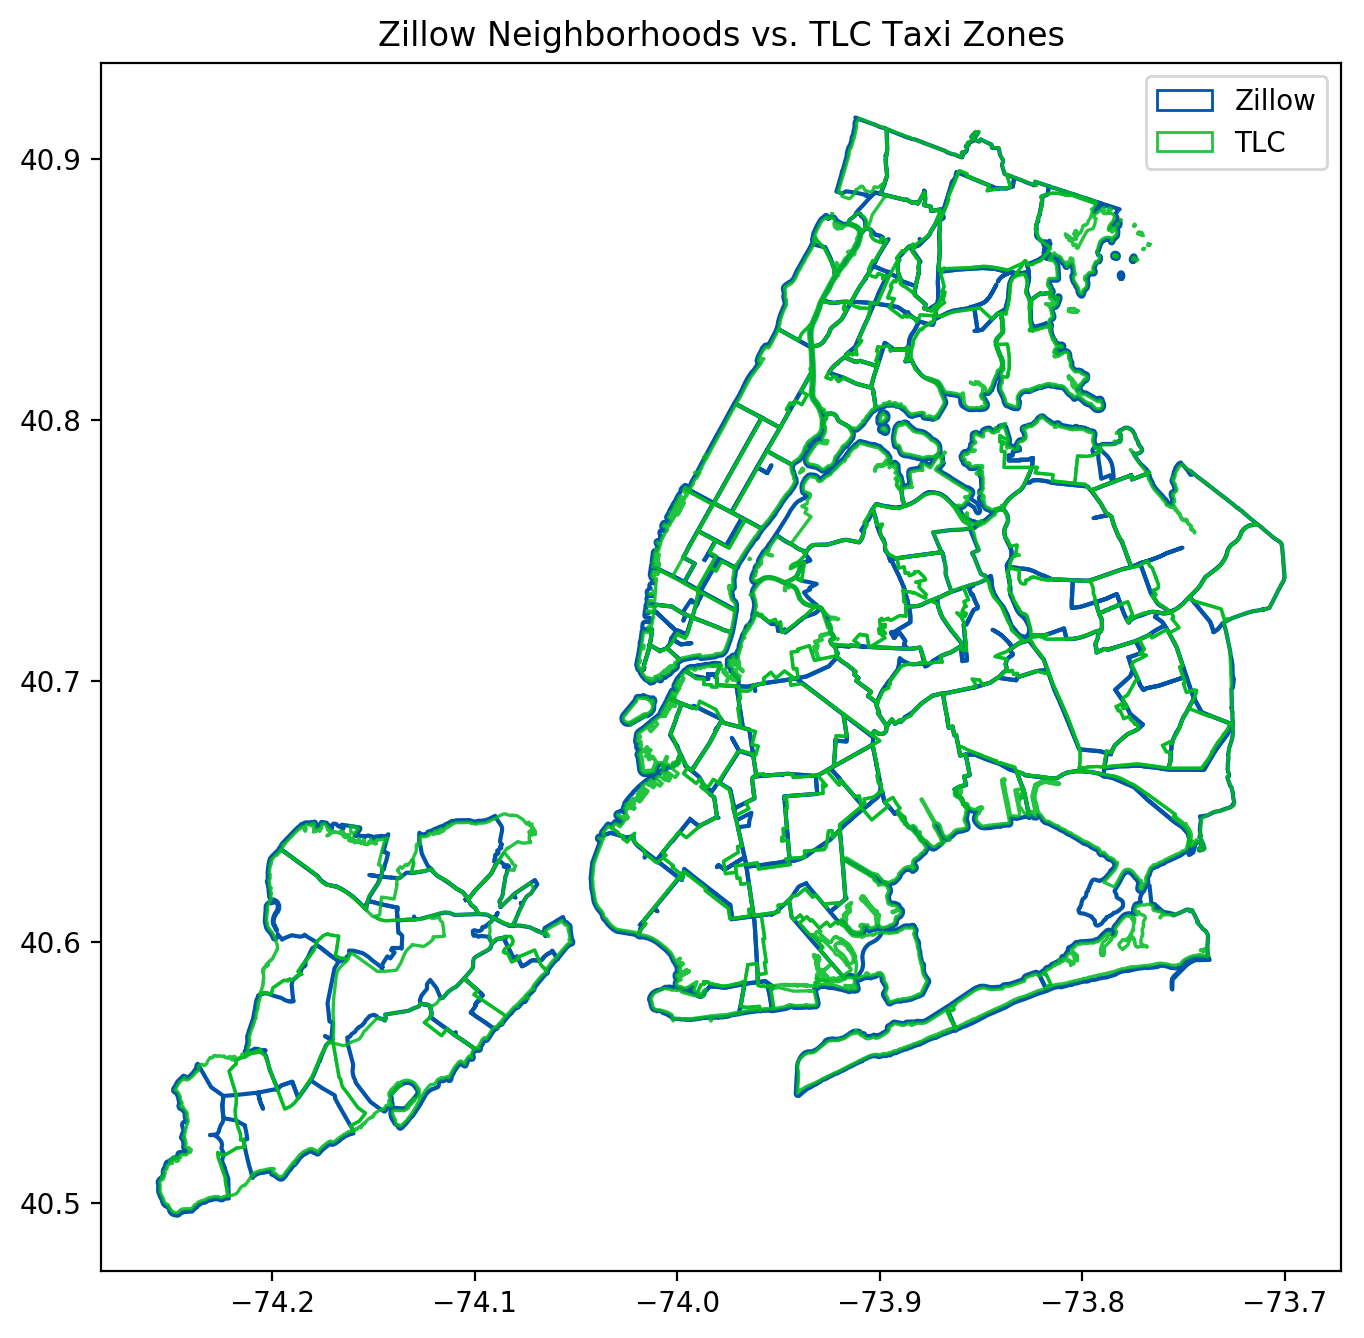

In [210]:
z_col = '#0055aaff'
t_col = '#00bb22dd'

z_patch = mpatches.Patch(facecolor='white', edgecolor=z_col, label='Zillow')
t_patch = mpatches.Patch(facecolor='white', edgecolor=t_col, label='TLC')

plt.figure(figsize=(8,8))
plt.title('Zillow Neighborhoods vs. TLC Taxi Zones')
[plot(z, color=z_col, linewidth=1.5) for z in z_shapes]
[plot(t, color=t_col, linewidth=1.2) for t in t_shapes]
plt.legend(handles=[z_patch, t_patch], loc='best')
plt.show()